## Figure 2A

In [1]:
library(tidyverse)
library(readxl)
library(vcfR)
library(VariantAnnotation)
library(rtracklayer)
library(Biostrings)
library(Rsamtools)

data = read_csv("../data/annotated-calls.csv")
data = data %>% filter(AF < 0.40, Dx != "ASD")
cov_info = read_tsv("../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]
data = data %>% filter(Dataset == "Chess")

## filter outlier
# data = data %>% filter(`Individual ID` != "CMC_MSSM_224") 

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplic

In [2]:
make_vcf <- function(data){
    c <- paste0("chr",data$CHROM)
    s <- data$POS 
    e <- as.integer(s+sapply(as.character(data$REF),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$REF)
    alt(v) <- DNAStringSetList(lapply(data$ALT, function(x){x}))
    mcols(v)$subject = data$`Individual ID`
    mcols(v)$VAF = data$AF
    return(v)
}

v_all = make_vcf(data)
v_scz = make_vcf(data %>% filter(Dx=="SCZ"))
v_ctrl = make_vcf(data %>% filter(Dx!= "SCZ"))



In [3]:
## DHS regression

epimark = rtracklayer::import("../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
#epimark = GenomicRanges::intersect(epimark,mapped_gr,ignore.strand=TRUE)

epimark$SCZ_sSNV = countOverlaps(epimark,v_scz)
epimark$CONT_sSNV = countOverlaps(epimark, v_ctrl)

epimark$bin_length = width(epimark)

plot_df = mcols(epimark) %>% as.data.frame()

n_dx= 61
n_ctrl = 25

analyze_df = plot_df %>% mutate(bin_length_scz = bin_length*n_dx, bin_length_ctrl = bin_length*n_ctrl) %>%
    pivot_longer(SCZ_sSNV:CONT_sSNV, names_to="Dx", values_to = "sSNV_burden")  %>% 
    mutate(bin_length0 = ifelse(Dx=="SCZ_sSNV", bin_length_scz, bin_length_ctrl))

summary(glm(cbind(sSNV_burden, bin_length0 - sSNV_burden) ~ Dx*log(score), family=binomial(link="log"), data=analyze_df))


Call:
glm(formula = cbind(sSNV_burden, bin_length0 - sSNV_burden) ~ 
    Dx * log(score), family = binomial(link = "log"), data = analyze_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.1751  -0.0282  -0.0213  -0.0182   7.0324  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -16.9158     0.4570 -37.012  < 2e-16 ***
DxSCZ_sSNV             -1.7806     0.5603  -3.178 0.001484 ** 
log(score)             -0.2571     0.1306  -1.969 0.048925 *  
DxSCZ_sSNV:log(score)   0.5073     0.1510   3.359 0.000781 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2226.8  on 375615  degrees of freedom
Residual deviance: 2211.5  on 375612  degrees of freedom
AIC: 2513.8

Number of Fisher Scoring iterations: 12


In [4]:
## Enrich for H3K27me3
## DHS regression

epimark = rtracklayer::import("../resources//E081-H3K27me3.broadPeak.gz")
# epimark = rtracklayer::import("../resources/dnase_files//fetal_npc_girkis.bed")
#epimark = GenomicRanges::intersect(epimark,mapped_gr,ignore.strand=TRUE)

epimark$SCZ_sSNV = countOverlaps(epimark,v_scz)
epimark$CONT_sSNV = countOverlaps(epimark, v_ctrl)

epimark$bin_length = width(epimark)

plot_df = mcols(epimark) %>% as.data.frame()

n_dx= 61
n_ctrl = 25

analyze_df = plot_df %>% mutate(bin_length_scz = bin_length*n_dx, bin_length_ctrl = bin_length*n_ctrl) %>%
    pivot_longer(SCZ_sSNV:CONT_sSNV, names_to="Dx", values_to = "sSNV_burden")  %>% 
    mutate(bin_length0 = ifelse(Dx=="SCZ_sSNV", bin_length_scz, bin_length_ctrl))

summary(glm(cbind(sSNV_burden, bin_length0 - sSNV_burden) ~ Dx*log(score+1), family=binomial(link="log"), data=analyze_df))



Call:
glm(formula = cbind(sSNV_burden, bin_length0 - sSNV_burden) ~ 
    Dx * log(score + 1), family = binomial(link = "log"), data = analyze_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7041  -0.0482  -0.0311  -0.0204   5.0001  

Coefficients:
                           Estimate Std. Error  z value Pr(>|z|)    
(Intercept)               -18.44001    0.16058 -114.833  < 2e-16 ***
DxSCZ_sSNV                  0.55417    0.18160    3.052 0.002277 ** 
log(score + 1)              0.27075    0.07450    3.634 0.000279 ***
DxSCZ_sSNV:log(score + 1)  -0.31780    0.08977   -3.540 0.000400 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4342.6  on 299767  degrees of freedom
Residual deviance: 4328.3  on 299764  degrees of freedom
AIC: 5098.2

Number of Fisher Scoring iterations: 11


In [5]:
## Plot results as barplots

epi_regression <-  function(v_scz,v_ctrl, epi_path){
    epimark = rtracklayer::import(epi_path)
    #epimark = GenomicRanges::intersect(epimark,mapped_gr,ignore.strand=TRUE)

    epimark$SCZ_sSNV = countOverlaps(epimark,v_scz)
    epimark$CONT_sSNV = countOverlaps(epimark, v_ctrl)

    epimark$bin_length = width(epimark)

    plot_df = mcols(epimark) %>% as.data.frame()

    n_dx= 61
    n_ctrl = 25

    analyze_df = plot_df %>% mutate(bin_length_scz = bin_length*n_dx, bin_length_ctrl = bin_length*n_ctrl) %>%
    pivot_longer(SCZ_sSNV:CONT_sSNV, names_to="Dx", values_to = "sSNV_burden")  %>% 
    mutate(bin_length0 = ifelse(Dx=="SCZ_sSNV", bin_length_scz, bin_length_ctrl))

    m0 = summary(glm(cbind(sSNV_burden, bin_length0 - sSNV_burden) ~ Dx*log(score+1), family=binomial(link="log"), data=analyze_df))
    c = coef(m0)
    return(c(p_val = c[4,4], beta = c[4,1], se=c[4,2], n_muts = sum(analyze_df$sSNV_burden)))
}

epi_list = c("../resources/E081-DNase.hotspot.fdr0.01.broad.bed.gz",
             "../resources/E081-H3K27me3.broadPeak.gz",
            "../resources/E081-H3K36me3.broadPeak.gz",
            "../resources/E081-H3K4me1.broadPeak.gz",
            "../resources/E081-H3K4me3.broadPeak.gz",
            "../resources/E081-H3K9me3.broadPeak.gz")

epi_res = lapply(epi_list, function(x){
    epi_regression(v_scz,v_ctrl, x)
})

p_val,beta,se,n_muts,epi_mark
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.0007567037,0.52971125,0.1572700,150,DHS
0.0004000118,-0.31779830,0.0897716,383,H3K27me3
0.5103996481,0.23039493,0.3500296,431,H3K36me3
0.1162386691,0.14506540,0.0923537,541,H3K4me1
0.8301837769,0.03594729,0.1676131,155,H3K4me3
0.5886322231,0.26349422,0.4872132,442,H3K9me3


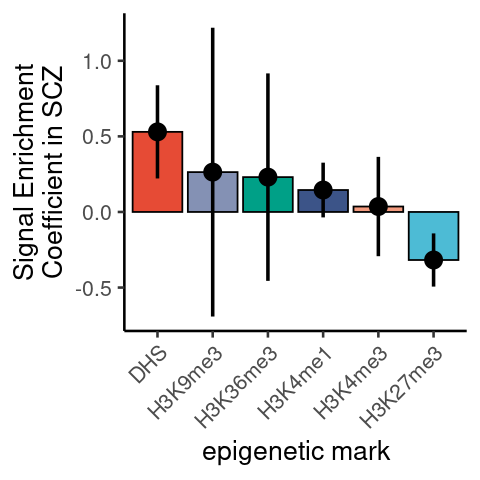

In [6]:
library("ggsci")
options(repr.plot.width=4, repr.plot.height=4)
epi_df = do.call(rbind, epi_res) %>% as.data.frame() %>% mutate(epi_mark = c("DHS","H3K27me3","H3K36me3",
                                                                                  "H3K4me1","H3K4me3","H3K9me3"))
epi_df
p1= epi_df %>% ggplot(aes(x=reorder(epi_mark,-beta),y=beta)) + geom_bar(stat="identity", aes(fill = epi_mark), color="black", show.legend=FALSE) +
    scale_fill_npg() + theme_classic(16) + 
    geom_pointrange(aes(ymin = beta - 1.96*se, ymax=beta + 1.96*se), color="black",size=1) +
    theme(axis.text.x = element_text(angle = 45, vjust = 1,hjust=1)) +
    labs(x="epigenetic mark", y = "Signal Enrichment\nCoefficient in SCZ", fill = "")
p1

# ggsave(p1, filename = "../figures/epi_enrichment.pdf",device="pdf",width=4,height=4)

## Figure 2B

In [7]:
## Get all the TF sites
library(plyranges)
tf_files = system("ls ../resources/hg19_cistrome/*.A.bed",intern = TRUE)
length(tf_files)

tf = lapply(tf_files, function(x){
    tmp = rtracklayer::import(x,format="BED")
    tf_name = gsub(pattern = "../resources/hg19_cistrome/|_HUMAN.A.bed",replacement = "",x = x)
    tmp$tf_name = tf_name
    #tmp = keepSeqlevels(tmp, c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "fine")
    seqlevelsStyle(tmp) <- "UCSC"
    return(tmp)
})

tf = keepSeqlevels(GRangesList(tf), c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "tidy")
tf_final = do.call("c",tf)
tf_final = tf_final[!duplicated(tf_final)]


Attaching package: ‘plyranges’


The following object is masked from ‘package:VariantAnnotation’:

    select


The following object is masked from ‘package:XVector’:

    slice


The following object is masked from ‘package:IRanges’:

    slice


The following objects are masked from ‘package:dplyr’:

    between, n, n_distinct


The following object is masked from ‘package:stats’:

    filter




[1] 138

In [8]:
library(biomaRt)
#ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")

listMarts(host="https://grch37.ensembl.org")
mart <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", GRCh=37, mirror="useast")
att <- listAttributes(mart)

# transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
#                                   "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
#       filters ="ensembl_gene_id",
#       values  =gene_names$ensembl_gene_id,
#       mart    =mart)


transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
                                  "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
      mart    =mart)

library(regioneR)
transcripts.gr <- toGRanges(transcripts)

#Filter out non-standard chromosomes
transcripts.gr <- keepSeqlevels(transcripts.gr, c(1:22,"X", "Y"), pruning.mode = "coarse")
colnames(mcols(transcripts.gr)) <- c("STRAND","ensembl_gene_id","transcription_start_site","hgnc_symbol")
## get the longest transcript
rd = splitAsList(transcripts.gr, transcripts.gr$ensembl_gene_id)
maxwd = which.max(width(rd))
refgene.longest = rd[splitAsList(unname(maxwd), names(maxwd))]

transcript.gr = unlist(refgene.longest)
seqlevelsStyle(transcript.gr) <- "UCSC"


biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 105
ENSEMBL_MART_SNP,Ensembl Variation 105
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 105


Warning message:
“version or GRCh arguments cannot be used together with the mirror argument.
We will ignore the mirror argument and connect to the main Ensembl site.”


In [9]:
ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)

## Using the generic TF regions and DHS combination

library(genomation)
peak_plot <- function(in_tss=TRUE, t){
    
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                              end=df$transcription_start_site),
                    strand=df$STRAND)
    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)

    dhs = rtracklayer::import("../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
    dhs$ntile = ntile(dhs$score,10)
    dhs = dhs[dhs$ntile==10]

    tf_ranges = tf_final
    h = findOverlaps(tf_ranges, tss.gr)
    strand(tf_ranges[queryHits(h)]) = strand(tss.gr[subjectHits(h)])
    if(in_tss){
        tfbs_regions = tf_ranges  %>% filter_by_overlaps(tss.gr) %>% filter_by_overlaps(dhs) 
    } else{
        tfbs_regions = tf_ranges %>% filter_by_overlaps(dhs) 
    }
    tfbs_regions = tfbs_regions %>% reduce_ranges()
    tfbs_regions = resize(tfbs_regions, width=20000,fix="center")

    bin_num = 11
    x = ScoreMatrixList(c(SCZ=granges(v_scz),CONT=granges(v_ctrl)), bin.num=bin_num, bin.op = "max", windows=tfbs_regions,
                        strand.aware=TRUE)
    n_dx=61
    n_ctrl = 25
    bin_size = 20000/bin_num
    plot_df = data.frame(SCZ = colMeans(x$SCZ)/(n_dx*bin_size)*10^6, 
                         CONT= colMeans(x$CONT)/(n_ctrl*bin_size)*10^6, 
                        tss_dist = seq(-10000,10000,length.out=bin_num)) 
    scz_counts = colSums(x$SCZ) 
    ctrl_counts = colSums(x$CONT) 
    print(poisson.test(c(as.integer(scz_counts[bin_num %/% 2 + 1L]), as.integer(ctrl_counts[bin_num %/% 2 + 1L])),
                c(n_dx*nrow(x$SCZ)*bin_size,n_ctrl*nrow(x$CONT)*bin_size)))

    p1 = plot_df %>% mutate(tss_dist = factor(as.character(tss_dist),levels=as.character(tss_dist))) %>% 
    mutate(SCZ_sites = n_dx*nrow(x$SCZ)*bin_size, ctrl_sites = n_ctrl*nrow(x$CONT)*bin_size) %>% 
    pivot_longer(SCZ:CONT, names_to = "Dx",values_to = "sSNV_burden") %>%
    mutate(low_ci = ifelse(Dx=="SCZ", sSNV_burden - 1.96*sqrt(sSNV_burden/(SCZ_sites/10^6)), sSNV_burden - 1.96*sqrt(sSNV_burden/(ctrl_sites/10^6)))) %>%
    mutate(high_ci = ifelse(Dx=="SCZ", sSNV_burden + 1.96*sqrt(sSNV_burden/(SCZ_sites/10^6)), sSNV_burden + 1.96*sqrt(sSNV_burden/(ctrl_sites/10^6)))) %>%
    ggplot(aes(x=tss_dist, y=sSNV_burden)) + 
    geom_pointrange(aes(ymin=low_ci, ymax=high_ci, color=Dx), size=1, position=position_dodge(width=0.6), alpha=0.8) +
    theme_classic(16) + labs(color="",x= "Signed distance from TFBS midpoint (bp)",y="sSNV/Mb",title=t) +
    scale_color_manual(values=c("darkorange","dodgerblue3")) +
    geom_vline(xintercept = "0",linetype=2,size=1,alpha=0.2) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "top") 

    return(p1)
}
    


## statistic test for promoter/TSS enrichment

# stat_df = plot_df %>% mutate(scz_counts = colSums(x$SCZ), ctrl_counts = colSums(x$CONT))
# stat_df





Loading required package: BSgenome

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern


Warning message:
“replacing previous import ‘Biostrings::pattern’ by ‘grid::pattern’ when loading ‘genomation’”


Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“174 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“505 windows fall off the target”



	Comparison of Poisson rates

data:  c(as.integer(scz_counts[bin_num%/%2 + 1L]), as.integer(ctrl_counts[bin_num%/%2 + 1L])) time base: c(n_dx * nrow(x$SCZ) * bin_size, n_ctrl * nrow(x$CONT) * bin_size)
count1 = 46, expected count1 = 37.813, p-value = 0.01403
alternative hypothesis: true rate ratio is not equal to 1
95 percent confidence interval:
 1.183562 6.928878
sample estimates:
rate ratio 
  2.639348 



Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“120 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“312 windows fall off the target”



	Comparison of Poisson rates

data:  c(as.integer(scz_counts[bin_num%/%2 + 1L]), as.integer(ctrl_counts[bin_num%/%2 + 1L])) time base: c(n_dx * nrow(x$SCZ) * bin_size, n_ctrl * nrow(x$CONT) * bin_size)
count1 = 25, expected count1 = 20.02, p-value = 0.03642
alternative hypothesis: true rate ratio is not equal to 1
95 percent confidence interval:
  1.013493 17.186932
sample estimates:
rate ratio 
  3.321476 



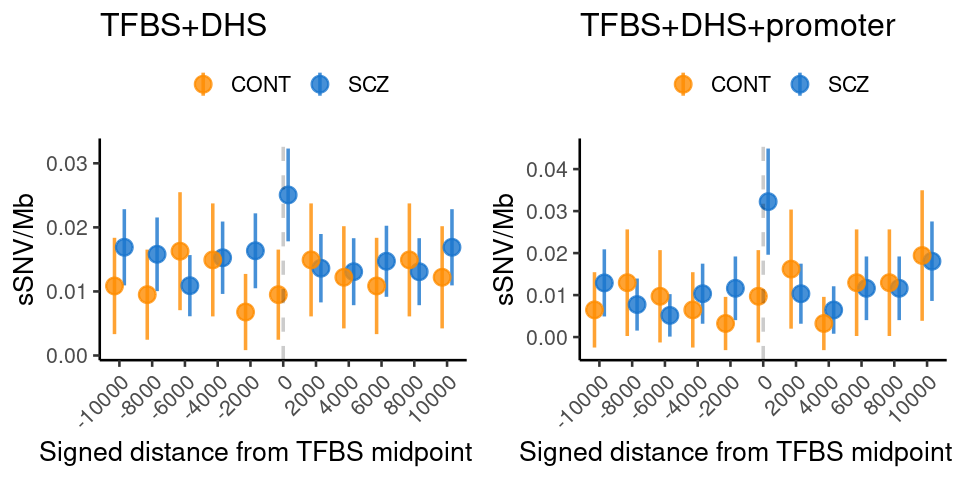

In [10]:
options(repr.plot.width=8, repr.plot.height=4)
p1 = peak_plot(in_tss=FALSE, t= "TFBS+DHS")
p2 = peak_plot(in_tss=TRUE, t="TFBS+DHS+promoter")
p3 = ggpubr::ggarrange(p1,p2, ncol=2, nrow=1)
p3
# ggsave(p3, filename = "../figures/peak_plots.pdf", device="pdf", width=8, height=4)

## Figure 2C

In [11]:
total_length = sum(seqlengths(BSgenome.Hsapiens.UCSC.hg19)[1:24])
total_length

[1] 3095677412

In [12]:
## Using cistrome data

get_tf_rate2 <- function(epi,target_vcf, d = 200, in_tss=TRUE){
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                          end=df$transcription_start_site),
                strand=df$STRAND)


    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)
    dhs = rtracklayer::import("../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
    dhs$ntile = ntile(dhs$score,20)
    dhs = dhs[dhs$ntile==20]
    if(in_tss){
        epi_promoter = epi %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) %>% reduce_ranges()
    } else{
        epi_promoter = epi %>% filter_by_overlaps(dhs) %>% reduce_ranges()
    }
    epi_promoter = resize(epi_promoter, width = d,fix="center")
    epi_promoter$intarget = countOverlaps(epi_promoter, target_vcf)
    return(c(num_muts = sum(epi_promoter$intarget), sites = sum(width(epi_promoter))))
}



diagnosis="SCZ"
expected_muts = table(data$Dx)["SCZ"]

distance_tf = c("5000","2000","1000","500","100","50")


library(parallel)
results_df = mclapply(distance_tf, function(x){
    get_tf_rate2(tf_final, granges(v_scz), d=2*as.numeric(x), in_tss=TRUE)
})

results_df = do.call(rbind, results_df)

results_df = results_df %>% data.frame %>% mutate(muts = num_muts - c(.$num_muts[2:length(distance_tf)],0))
results_df = results_df %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf), RR=0, low_ci=0, high_ci=0, pval=0)
for(i in 1:nrow(results_df)){
    res = poisson.test(c(results_df$muts[i], expected_muts), c(results_df$sites[i], total_length))
    results_df$RR[i] = res$estimate; results_df$low_ci[i] = res$conf.int[1]
    results_df$high_ci[i] = res$conf.int[2]; results_df$pval[i] = res$p.value
    
}

options(repr.plot.width=4, repr.plot.height=4)
results_df
p1 = results_df %>% ggplot(aes(x=dist_tf,y=RR)) + geom_bar(stat="identity",color="black",fill="#91D1C2FF",alpha=1) + 
    theme_classic(16) + 
    labs(x="Distance to\nTFBS mid-point", y="RR",title=paste("SCZ sSNV rate\nactive TFBS + promoter")) +
    geom_pointrange(aes(ymin=low_ci, ymax=high_ci)) + geom_hline(yintercept = 1, linetype=2) +
    ylim(c(0,25)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0.05-0.1Kb","0-0.05Kb"))


results_df = mclapply(distance_tf, function(x){
    get_tf_rate2(tf_final, granges(v_scz), d=2*as.numeric(x), in_tss=FALSE)
})

results_df = do.call(rbind, results_df)

results_df = results_df %>% data.frame %>% mutate(muts = num_muts - c(.$num_muts[2:length(distance_tf)],0))
results_df = results_df %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf), RR=0, low_ci=0, high_ci=0, pval=0)
for(i in 1:nrow(results_df)){
    res = poisson.test(c(results_df$muts[i], expected_muts), c(results_df$sites[i], total_length))
    results_df$RR[i] = res$estimate; results_df$low_ci[i] = res$conf.int[1]
    results_df$high_ci[i] = res$conf.int[2]; results_df$pval[i] = res$p.value
    
}

options(repr.plot.width=4, repr.plot.height=4)
results_df
p2 = results_df %>% ggplot(aes(x=dist_tf,y=RR)) + geom_bar(stat="identity",color="black",fill="#91D1C2FF",alpha=1) + 
    theme_classic(16) + 
    labs(x="Distance to\nTFBS mid-point", y="RR",title=paste("SCZ sSNV rate\nactive TFBS")) +
    geom_pointrange(aes(ymin=low_ci, ymax=high_ci)) + geom_hline(yintercept = 1, linetype=2) +
    ylim(c(0,25)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
     scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0.05-0.1Kb","0-0.05Kb"))



num_muts,sites,muts,dist_tf,RR,low_ci,high_ci,pval
<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
44,47010000,16,5000,0.4350221,0.2482506,0.7079043,0.0002196448
28,18804000,10,2000,0.6797220,0.3255364,1.2521986,0.2921511411
18,9402000,7,1000,0.9516108,0.3821879,1.9636874,1.0000000000
11,4701000,4,500,1.0875552,0.2960832,2.7881629,0.7903286033
7,940200,4,100,5.4377759,1.4804161,13.9408147,0.0068446034
3,470100,3,50,8.1566638,1.6809269,23.8656284,0.0063224868


num_muts,sites,muts,dist_tf,RR,low_ci,high_ci,pval
<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
87,88960000,38,5000,0.5459720,0.3854016,0.7515757,6.508608e-05
49,35584000,20,2000,0.7183842,0.4380145,1.1119790,1.517866e-01
29,17792000,10,1000,0.7183842,0.3440527,1.3234230,3.467670e-01
19,8896000,11,500,1.5804453,0.7878946,2.8329224,1.263292e-01
8,1779200,3,100,2.1551527,0.4441343,6.3057733,1.647558e-01
5,889600,5,50,7.1838423,2.3304689,16.7877805,7.696022e-04


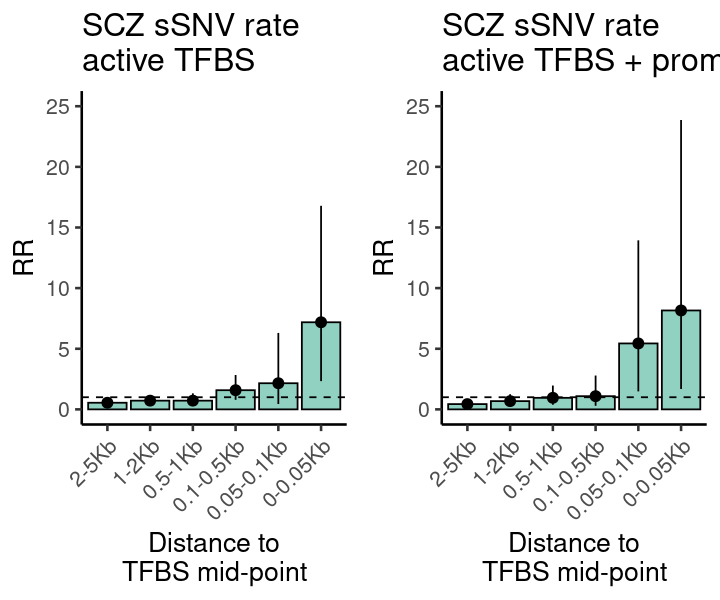

In [13]:
options(repr.plot.height=5, repr.plot.width=6)
p3 = ggpubr::ggarrange(p2,p1, nrow=1,ncol=2)
p3
# ggsave(p3,filename = "../figures/TFBS_dhs_barplots.pdf",device="pdf",width=4, height=4)

## Figure 3D

In [14]:
get_tf_rate <- function(epi,target_vcf,dhs,d = 200){
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                          end=df$transcription_start_site),strand=df$STRAND)

    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)
    dhs$ntile = ntile(dhs$score, 20)
    dhs = dhs[dhs$ntile==20]
    epi_promoter = epi %>% filter_by_overlaps(dhs) %>% reduce_ranges()
    epi_promoter = resize(epi_promoter, width = d,fix="center")
    epi_promoter$target = countOverlaps(epi_promoter, target_vcf)
    
    
    return(c(num_muts = sum(epi_promoter$target), sites = sum(width(epi_promoter))))
}

get_rr <- function(dhs){
    distance_tf = c("5000","2000","1000","500","100")

    library(parallel)
    results_df = mclapply(distance_tf, function(x){
        get_tf_rate(tf_final, granges(v_scz), dhs, d=2*as.numeric(x))
    })

    results_df = do.call(rbind, results_df)
    results_df = results_df %>% data.frame %>% mutate(muts = num_muts - c(.$num_muts[2:length(distance_tf)],0))
    results_df = results_df %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf), RR=0, low_ci=0, high_ci=0, pval=0)
    for(i in 1:nrow(results_df)){
        res = poisson.test(c(results_df$muts[i], expected_muts), c(results_df$sites[i], total_length))
        results_df$RR[i] = res$estimate; results_df$low_ci[i] = res$conf.int[1]
        results_df$high_ci[i] = res$conf.int[2]; results_df$pval[i] = res$p.value

    }

    return(results_df)
    
}

## Plotting base change profiles at DHS sites

ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)
expected_muts = table(data$Dx)["SCZ"]
total_length = sum(seqlengths(BSgenome.Hsapiens.UCSC.hg19)[1:24])

In [15]:
dnase_list = system("ls ../resources/dnase_files/*",intern  =TRUE)

res = lapply(dnase_list, function(x){
    tmp = rtracklayer::import(x,format = "BED")
    tmp2 = get_rr(tmp)
    tmp2$tissue = gsub("../resources/dnase_files/|.bed","",x)
    return(tmp2)
})

res = do.call(rbind, res)

In [16]:
tiss_ord = res %>% filter(dist_tf == 100) %>% arrange(RR) %>% pull(tissue)

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



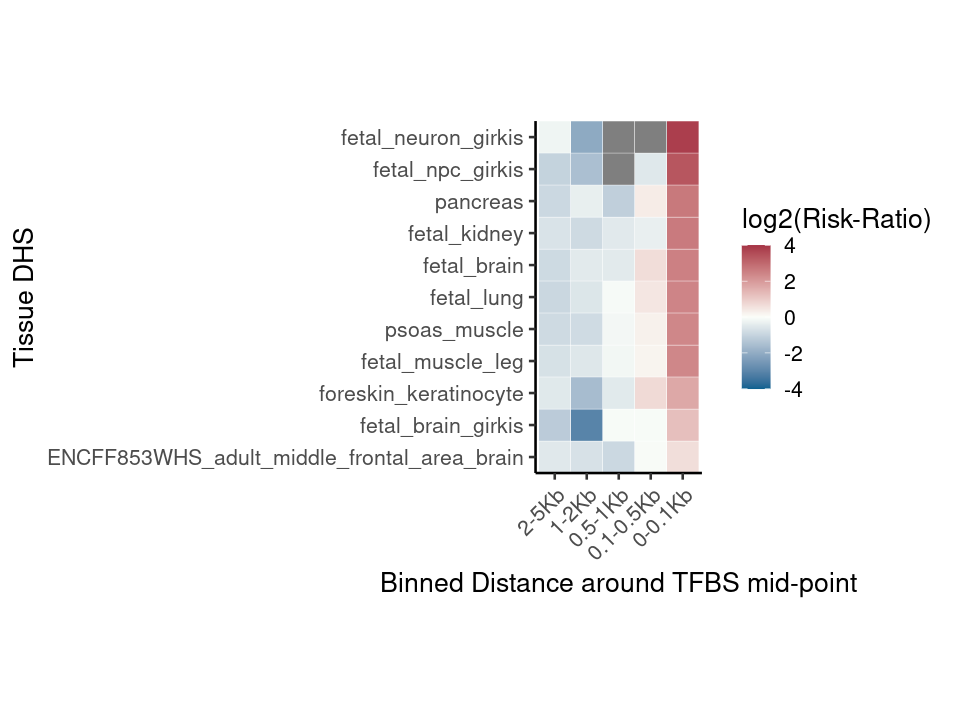

In [17]:
options(repr.plot.width=8, repr.plot.height=6)
p1 = res %>% mutate(tissue = factor(tissue, levels=tiss_ord)) %>% 
    ggplot(aes(x=dist_tf, y=tissue, fil=log2(RR))) + geom_tile(col="white", aes(fill=log2(RR))) + 
    labs(x="Binned Distance around TFBS mid-point", y= "Tissue DHS",
                                                      fill = "log2(Risk-Ratio)",size="-log10(p-value)") +
    theme_classic(16) +
    scale_fill_gradient2(mid="#FBFEF9",low="#0C6291",high="#A63446", limits=c(-4,4)) +
     scale_x_discrete(expand=c(0,0)) +
    scale_y_discrete(expand=c(0,0)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1,vjust=1)) +
    coord_fixed() +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
p1

# ggsave(p1, filename="../figures/heatmap_multiple_dhs.pdf", device="pdf",width=8, height=6)

## Figure 2E

In [18]:
get_tf_rate2 <- function(epi,target_vcf,dhs,d = 200){
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                          end=df$transcription_start_site),strand=df$STRAND)

    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)
#     dhs$ntile = ntile(dhs$score, 20)
#     dhs = dhs[dhs$ntile==20]
    epi_promoter = epi %>% filter_by_overlaps(dhs) %>% reduce_ranges()
    epi_promoter = resize(epi_promoter, width = d,fix="center")
    epi_promoter$target = countOverlaps(epi_promoter, target_vcf)
    
    
    return(c(num_muts = sum(epi_promoter$target), sites = sum(width(epi_promoter))))
}

get_rr2 <- function(dhs){
    distance_tf = c("5000","2000","1000","500","100")

    library(parallel)
    results_df = mclapply(distance_tf, function(x){
        get_tf_rate(tf_final, granges(v_scz), dhs, d=2*as.numeric(x))
    })

    results_df = do.call(rbind, results_df)
    results_df = results_df %>% data.frame %>% mutate(muts = num_muts - c(.$num_muts[2:length(distance_tf)],0))
    results_df = results_df %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf), RR=0, low_ci=0, high_ci=0, pval=0)
    for(i in 1:nrow(results_df)){
        res = poisson.test(c(results_df$muts[i], expected_muts), c(results_df$sites[i], total_length))
        results_df$RR[i] = res$estimate; results_df$low_ci[i] = res$conf.int[1]
        results_df$high_ci[i] = res$conf.int[2]; results_df$pval[i] = res$p.value

    }

    return(results_df)
    
}

In [19]:
distance_tf = c("5000","2000","1000","500","100","50")

dhs_fetal_brain = rtracklayer::import("../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_lung = rtracklayer::import("../resources/E088-fetal_lung_DNase.hotspot.fdr0.01.broad.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_kidney = rtracklayer::import("../resources//E086-fetal_kidney_DNase.hotspot.fdr0.01.broad.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_pancreas = rtracklayer::import("../resources//E098-pancreas_DNase.hotspot.fdr0.01.broad.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_brain_girkis = rtracklayer::import("../resources/dnase_files/fetal_brain_girkis.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_neuron_girkis = rtracklayer::import("../resources/dnase_files/fetal_neuron_girkis.bed",format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_npc_girkis = rtracklayer::import("../resources/dnase_files/fetal_npc_girkis.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_muscle_leg = rtracklayer::import("../resources/dnase_files/fetal_muscle_leg.bed",format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_adult_keratinocyte = rtracklayer::import("../resources/dnase_files/foreskin_keratinocyte.bed", format = "BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_adult_pancreas = rtracklayer::import("../resources/dnase_files/pancreas.bed", format = "BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_adult_psoas = rtracklayer::import("../resources/dnase_files/psoas_muscle.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_adult_brain = rtracklayer::import("../resources/dnase_files/ENCFF853WHS_adult_middle_frontal_area_brain.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)

dhs_fetal = dhs_fetal_brain %>% bind_ranges(dhs_fetal_brain_girkis) %>% 
    bind_ranges(dhs_fetal_npc_girkis) %>% bind_ranges(dhs_fetal_neuron_girkis) %>%
    bind_ranges(dhs_fetal_lung) %>% bind_ranges(dhs_fetal_kidney) %>%
    bind_ranges(dhs_fetal_muscle_leg)

dhs_adult = dhs_adult_keratinocyte %>% bind_ranges(dhs_adult_pancreas) %>%
    bind_ranges(dhs_adult_psoas) %>% bind_ranges(dhs_adult_brain)

dhs_fetal_only = dhs_fetal %>% filter_by_non_overlaps(dhs_adult)
dhs_adult_only = dhs_adult %>% filter_by_non_overlaps(dhs_fetal)

length(dhs_fetal_only)
length(dhs_adult_only)


library(parallel)
results_df = mclapply(distance_tf, function(x){
    get_tf_rate2(tf_final, granges(v_scz), dhs_adult_only, d=2*as.numeric(x))
})

results_df = do.call(rbind, results_df)
results_df = results_df %>% data.frame %>% mutate(muts = num_muts - c(.$num_muts[2:length(distance_tf)],0))
results_df = results_df %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf), RR=0, low_ci=0, high_ci=0, pval=0)
for(i in 1:nrow(results_df)){
    res = poisson.test(c(results_df$muts[i], expected_muts), c(results_df$sites[i], total_length))
    results_df$RR[i] = res$estimate; results_df$low_ci[i] = res$conf.int[1]
    results_df$high_ci[i] = res$conf.int[2]; results_df$pval[i] = res$p.value

}


results_df_adult = results_df
results_df_adult$age = "adult"


library(parallel)
results_df = mclapply(distance_tf, function(x){
    get_tf_rate2(tf_final, granges(v_scz),dhs_fetal_only, d=2*as.numeric(x))
})

results_df = do.call(rbind, results_df)
results_df = results_df %>% data.frame %>% mutate(muts = num_muts - c(.$num_muts[2:length(distance_tf)],0))
results_df = results_df %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf), RR=0, low_ci=0, high_ci=0, pval=0)
for(i in 1:nrow(results_df)){
    res = poisson.test(c(results_df$muts[i], results_df$sites[i] ), c(expected_muts, total_length))
    results_df$RR[i] = res$estimate; results_df$low_ci[i] = res$conf.int[1]
    results_df$high_ci[i] = res$conf.int[2]; results_df$pval[i] = res$p.value

}



results_df_fetal = results_df
results_df_fetal$age = "fetal"




[1] 17277

[1] 1566271

In [20]:
library(ggsci)
options(repr.plot.width=4, repr.plot.height=4)
results_df_age = rbind(results_df_adult,results_df_fetal)
p1 = results_df_age %>% ggplot(aes(x=dist_tf,y=RR)) + 
    #geom_line(aes(color=age, group=age),size=1) + 
    geom_pointrange(aes(ymin=low_ci,ymax=high_ci, color=age), size=1, position = position_dodge2(width = 0.5)) + 
    theme_classic(16)+
    geom_hline(yintercept = 1,linetype=2) +
    scale_color_npg(alpha=1, labels=c("adult DHS","fetal DHS")) +
    labs(x="Distance to TFBS midpoint (bp) ", y ="Risk Ratio", color="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "top") +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0.05-0.1Kb","0-0.05Kb"))

In [21]:
distance_tf = c("5000","2000","1000","500","100","50")


dhs_fetal_brain = rtracklayer::import("../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_lung = rtracklayer::import("../resources/E088-fetal_lung_DNase.hotspot.fdr0.01.broad.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_kidney = rtracklayer::import("../resources//E086-fetal_kidney_DNase.hotspot.fdr0.01.broad.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_pancreas = rtracklayer::import("../resources//E098-pancreas_DNase.hotspot.fdr0.01.broad.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_brain_girkis = rtracklayer::import("../resources/dnase_files/fetal_brain_girkis.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_neuron_girkis = rtracklayer::import("../resources/dnase_files/fetal_neuron_girkis.bed",format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_npc_girkis = rtracklayer::import("../resources/dnase_files/fetal_npc_girkis.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_fetal_muscle_leg = rtracklayer::import("../resources/dnase_files/fetal_muscle_leg.bed",format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_adult_keratinocyte = rtracklayer::import("../resources/dnase_files/foreskin_keratinocyte.bed", format = "BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_adult_pancreas = rtracklayer::import("../resources/dnase_files/pancreas.bed", format = "BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_adult_psoas = rtracklayer::import("../resources/dnase_files/psoas_muscle.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)
dhs_adult_brain = rtracklayer::import("../resources/dnase_files/ENCFF853WHS_adult_middle_frontal_area_brain.bed", format="BED") %>%
    mutate(ntile = ntile(score,20)) %>% filter(ntile ==20)


dhs_brain_all =  dhs_fetal_brain %>% bind_ranges(dhs_fetal_brain_girkis) %>%
    bind_ranges(dhs_fetal_npc_girkis) %>%
    bind_ranges(dhs_fetal_neuron_girkis) 


dhs_non_brain_all = dhs_fetal_lung %>% bind_ranges(dhs_fetal_kidney) %>%
    bind_ranges(dhs_fetal_muscle_leg) 

dhs_brain_only = dhs_brain_all %>% filter_by_non_overlaps(dhs_non_brain_all)
dhs_non_brain_only = dhs_non_brain_all %>% filter_by_non_overlaps(dhs_brain_all)


length(dhs_fetal_only)
length(dhs_adult_only)



library(parallel)
results_df = mclapply(distance_tf, function(x){
    get_tf_rate2(tf_final, granges(v_scz),dhs_brain_only, d=2*as.numeric(x))
})

results_df = do.call(rbind, results_df)
results_df = results_df %>% data.frame %>% mutate(muts = num_muts - c(.$num_muts[2:length(distance_tf)],0))
results_df = results_df %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf), RR=0, low_ci=0, high_ci=0, pval=0)
for(i in 1:nrow(results_df)){
    res = poisson.test(c(results_df$muts[i], expected_muts), c(results_df$sites[i], total_length))
    results_df$RR[i] = res$estimate; results_df$low_ci[i] = res$conf.int[1]
    results_df$high_ci[i] = res$conf.int[2]; results_df$pval[i] = res$p.value

}


results_df_brain = results_df
results_df_brain$tissue = "brain"



results_df = mclapply(distance_tf, function(x){
    get_tf_rate2(tf_final, granges(v_scz),dhs_non_brain_only, d=2*as.numeric(x))
})

results_df = do.call(rbind, results_df)
results_df = results_df %>% data.frame %>% mutate(muts = num_muts - c(.$num_muts[2:length(distance_tf)],0))
results_df = results_df %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf), RR=0, low_ci=0, high_ci=0, pval=0)
for(i in 1:nrow(results_df)){
    res = poisson.test(c(results_df$muts[i], expected_muts), c(results_df$sites[i], total_length))
    results_df$RR[i] = res$estimate; results_df$low_ci[i] = res$conf.int[1]
    results_df$high_ci[i] = res$conf.int[2]; results_df$pval[i] = res$p.value

}


results_df_non_brain = results_df
results_df_non_brain$tissue = "non brain"



[1] 17277

[1] 1566271

In [22]:
library(ggsci)
options(repr.plot.width=4, repr.plot.height=4)
results_df_tissue = rbind(results_df_brain,results_df_non_brain)
p2= results_df_tissue %>% ggplot(aes(x=dist_tf,y=RR)) + 
    #geom_line(aes(color=age, group=age),size=1) + 
    geom_pointrange(aes(ymin=low_ci,ymax=high_ci, color=tissue), size=1, position = position_dodge2(width = 0.8)) + 
    theme_classic(16)+
    geom_hline(yintercept = 1,linetype=2) +
#     scale_color_npg(alpha=1, labels=c("brain DHS","non-brain DHS")) +
    scale_color_manual(values=c('#00A087FF','#3C5488FF'), labels=c("brain DHS","non-brain DHS")) +
    labs(x="Distance to TFBS midpoint (bp) ", y ="Risk Ratio", color="") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "top") +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0.05-0.1Kb","0-0.05Kb"))

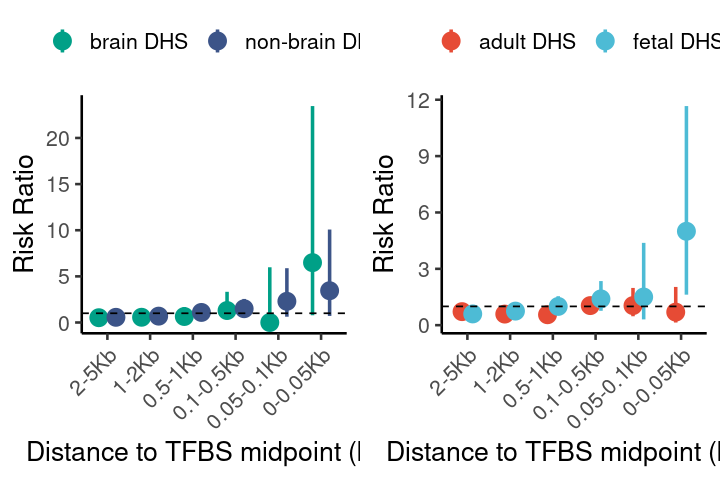

In [23]:
options(repr.plot.width=6, repr.plot.height=4)
p3 = ggpubr::ggarrange(p2,p1, ncol=2,nrow=1)
p3
# ggsave(p3,filename = "../figures/fetal_vs_brain.pdf", device="pdf", width=6,height=4)

In [24]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.2.19/lib/libopenblas_core2p-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  grid      stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] genomation_1.26.0                 BSgenome.Hsapiens.UCSC.hg19_1.4.3
 [3] BSgenome_1.62.0                   regioneR_1.26.0                  
 [5] biomaRt_2.50.1                    plyranges_1.14.0                 
 [7] ggsci_2.9                         rtracklayer_1.54.